<a href="https://colab.research.google.com/github/Duirta/Stock-Portfolio-Allocator/blob/main/Quantum_Portfolio_Optimization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install qiskit

In [ ]:
from qiskit import Aer
from qiskit.circuit.library import TwoLocal
from qiskit.aqua import QuantumInstance
from qiskit.finance.applications.ising import portfolio
from qiskit.optimization.applications.ising.common import sample_most_likely
from qiskit.finance.data_providers import RandomDataProvider
from qiskit.aqua.algorithms import VQE, QAOA, NumPyMinimumEigensolver
from qiskit.aqua.components.optimizers import COBYLA
import numpy as np
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import yfinance as yf

In [ ]:
companies = open('sp_500_stocks.csv','r')
companies = companies.readlines()
companies = [i.replace('\n','') for i in companies[1:]]

In [ ]:
def get_stock(company_name,start_date='2016-01-01',end_date='2019-08-01'):
  company = yf.download(company_name,'2016-01-01','2019-08-01')
  datas = np.array(company.index)
  company_price = np.array(company['Adj Close'])
  y = np.log(company_price)/np.log(10)
  r = np.array([y[n]-y[n-1] for n in range(1,len(y)) if str(y[n]-y[n-1]) != 'nan'])
  return company_price, r

def get_date(start_date,end_date):
  company = yf.download('AAPL',start_date,end_date)
  datas = np.array(company.index)
  return datas

In [ ]:
r = dict()
stock_price = dict()
datas = get_date('2016-01-01','2019-08-01')
for company in companies:
  stock_company, r_company = get_stock(company)
  if len(r_company) == len(datas)-1:
    r[company] = r_company
  if len(stock_company) == len(datas):
    stock_price[company] = stock_company

In [ ]:
df_stock = pd.DataFrame(data=stock_price, index = datas)
df_stock

,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,ADP,ADSK,AEE,AEP,AES,AFL,AIG,AIV,AIZ,AJG,AKAM,ALB,ALGN,ALK,ALL,ALLE,ALXN,AMAT,AMD,AME,AMGN,AMP,AMT,AMZN,ANET,ANSS,ANTM,AON,AOS,...,V,VAR,VFC,VLO,VMC,VNO,VRSK,VRSN,VRTX,VTR,VZ,WAB,WAT,WBA,WDC,WEC,WELL,WFC,WHR,WLTW,WM,WMB,WMT,WRB,WRK,WST,WU,WY,WYNN,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZBRA,ZION,ZTS
2016-01-04,39.095455,150.042603,24.400942,45.658573,93.250946,85.239998,38.764435,93.090912,91.970001,48.751160,30.572958,73.417427,60.310001,37.141426,49.198906,7.748261,26.283363,52.719463,3.343637,70.149368,35.706768,52.310001,51.372169,64.269997,72.493584,55.051224,61.517063,184.679993,17.168798,2.770000,50.854450,137.679718,91.021645,87.649292,636.989990,77.400002,90.099998,129.747482,85.578888,34.700645,...,73.183807,68.968185,50.526230,56.247974,88.293922,62.928524,74.305283,83.949997,122.889999,43.688343,36.341522,68.104347,130.350006,72.487892,52.125351,43.895477,53.365490,44.764740,127.593910,115.985748,47.118961,19.169983,54.826603,31.865736,34.330246,56.028664,14.665780,24.703295,62.285862,30.728559,41.560146,61.158344,56.801006,19.778408,33.827049,47.279510,97.778976,66.489998,24.061127,45.639774
2016-01-05,38.722763,149.017624,23.789471,45.468349,94.614861,85.000000,38.755398,93.575417,92.339996,48.392967,30.914169,73.596344,60.389999,37.581642,49.603764,7.855074,26.247833,52.902676,3.428810,71.319725,35.804474,52.020000,50.586109,64.949997,71.282310,54.924198,61.450333,184.899994,17.187387,2.750000,50.593651,137.531876,90.663673,89.380524,633.789978,78.279999,89.419998,131.639481,86.097786,34.506790,...,73.734848,69.134796,50.816753,57.229149,88.418137,63.759697,74.038841,81.410004,123.449997,44.458313,36.840652,66.910400,129.809998,70.585129,51.900967,44.365913,54.692017,44.747814,124.845413,116.783737,47.298641,19.235733,56.129028,32.140755,34.307621,55.318573,14.607517,24.761265,63.463280,31.038425,42.177193,61.679451,57.959030,19.740007,33.817661,47.161652,99.815056,64.820000,23.799892,46.354256
2016-01-06,39.401257,145.075378,23.323915,45.476276,93.168549,85.300003,38.430336,93.392578,91.019997,46.333305,30.163494,72.692825,59.540001,37.823311,49.789322,7.583928,25.848118,52.126232,3.390018,70.381660,35.111656,50.480000,48.375851,64.870003,72.308655,54.307175,59.839241,184.070007,16.480927,2.510000,49.444229,136.271088,87.581566,89.063278,632.650024,73.529999,88.290001,128.423965,84.795845,33.823669,...,72.768089,68.775269,49.961773,56.827011,86.364113,63.459209,73.654007,81.019997,122.230003,44.050220,36.507820,64.570992,129.710007,69.502846,50.744541,44.246170,54.574982,43.893295,121.657501,111.345467,47.882561,16.729898,56.691048,31.734207,33.357357,55.688210,14.274582,24.214693,60.175541,31.365505,41.405876,61.166237,57.119465,19.490376,33.395763,46.827736,100.247200,62.230000,23.106249,46.363911
2016-01-07,38.655853,146.681824,22.339539,45.341534,90.193527,81.919998,37.509308,90.650055,89.110001,45.151234,29.446941,70.474297,55.980000,37.849205,49.215782,7.394944,25.408432,50.878693,3.370622,68.800369,34.383305,48.189999,46.193348,63.500000,68.415833,53.027760,58.113747,174.369995,15.997561,2.280000,48.275497,133.019058,84.805099,86.842606,607.940002,68.750000,87.230003,126.224380,83.559944,32.171246,...,71.337288,67.345917,49.347519,57.977062,84.357880,62.832607,72.075134,80.550003,114.959999,43.280251,36.307316,62.416054,128.820007,70.846992,49.907436,44.237617,53.014355,42.641140,118.598854,106.677444,47.316589,15.056913,58.011307,31.196135,33.025517,54.462589,14.191350,23.320307,54.514839,31.486008,39.772518,60.187199,56.617657,18.952709,32.533215,45.230145,97.942261,59.410000,22.412613,44.954262
2016-01-08,38.579407,143.459030,22.457672,44.105175,89.671753,84.580002,36.723721,89.772430,87.849998,44.757225,29.336050,69.892822,55.060001,37.555737,49.139866,7.501760,25.186369,50.119698,3.306533,67.960564,34.019123,48.099998,45.324032,64.529999,65.077812,52.837204,56.979309,168.130005,15.607152,2.140000,47.396534,131.045303,82.892975,85.410469,607.049988,68.870003

In [ ]:
df_r = pd.DataFrame(data=r)
cov = np.array(pd.DataFrame.cov(df_r))
companies = np.array(list(r.keys()))
mu = np.array([[np.mean(r[company]) for company in r.keys()]]).T

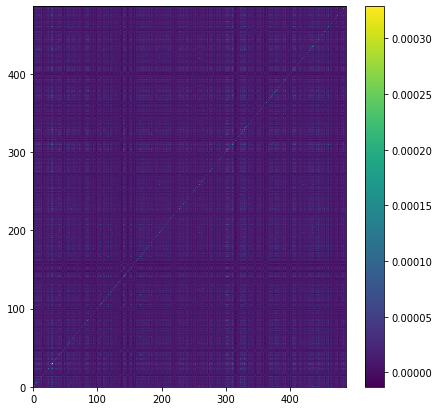

In [ ]:
plt.figure(figsize = (7,7))
plt.pcolor(cov)
plt.axis('tight')
plt.colorbar()
plt.show()

In [ ]:
from sklearn.cluster import KMeans

model = KMeans(n_clusters = 7)
model.fit(cov)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=7, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [ ]:
df_r = df_r.transpose()
df_r['Group'] = pd.Series(model.labels_, index = df_r.index)
df_r = df_r.iloc[np.argsort(model.labels_)]
df_r = df_r.transpose()
df_r

,JBHT,CVX,NRG,DD,DE,NLOK,NKE,DHI,MTD,MTB,DISCA,DISCK,DOV,MMM,MLM,MHK,DVA,MAS,NSC,EBAY,CTXS,CTAS,PSX,PRGO,PPG,PNC,PKG,PHM,CMI,PBCT,OXY,HII,ORCL,NWSA,NWS,NWL,CPRT,CSCO,CSX,CTSH,...,ROK,UNM,BLK,SYF,SWK,STT,PWR,LNC,BWA,BEN,C,RHI,CAT,SCHW,RJF,CFG,CBRE,EMN,RF,AMP,PRU,BAC,PH,UAL,CE,CMA,TXT,FLS,FITB,KEY,IVZ,TROW,APTV,ZION,PNR,FDX,JPM,LYB,J,UAA
0,0.004483,0.003699,0.016265,-0.003318,0.002504,0.000833,0.006029,0.000429,0.002682,0.002396,0.000986,0.001895,-0.008323,0.001889,-0.008493,-0.000933,0.002837,-0.001722,0.002435,-0.005124,-0.003646,0.000688,0.004961,0.000548,0.001549,0.000606,-0.000418,0.004031,-0.004269,-0.000275,0.007157,0.009680,-0.001338,-0.014712,-0.018166,-0.000200,0.000806,-0.001978,-0.004401,0.000000,...,-0.003910,-0.002260,0.001120,0.002459,-0.009039,0.000666,-0.018567,0.000354,-0.007047,-0.000721,-0.002299,0.001410,-0.004559,-0.001360,0.000924,-0.002025,0.003805,0.003118,-0.000921,-0.001711,-0.001471,0.000000,-0.007249,-0.004317,0.005222,-0.004743,0.001045,-0.009300,0.001331,-0.003702,-0.001179,0.001791,-0.012218,-0.004741,-0.003717,0.003678,0.000750,0.002285,-0.006156,0.002663
1,-0.006926,-0.017505,-0.035519,-0.009660,-0.004909,-0.000625,-0.006241,-0.010988,-0.008791,-0.008877,-0.003129,-0.002932,-0.009292,-0.008836,-0.011064,-0.009272,-0.006074,-0.003397,-0.014983,0.004795,0.002590,-0.001969,-0.016223,0.004843,-0.008205,-0.007940,-0.009587,-0.009634,-0.002003,-0.004153,-0.020037,0.001536,0.002188,-0.002045,0.003957,-0.012172,-0.008014,-0.004650,-0.020195,-0.007536,...,-0.011770,-0.012029,-0.004970,-0.003040,-0.006046,-0.014691,-0.000447,-0.020077,-0.014446,-0.011205,-0.006365,-0.011696,-0.006897,-0.015109,-0.017261,-0.006818,-0.019104,-0.008495,-0.007440,-0.015021,-0.014710,-0.009352,-0.005795,0.001103,-0.011506,-0.005010,-0.013250,-0.008964,-0.006471,-0.007844,-0.007544,-0.009846,-0.011697,-0.012846,-0.010071,-0.011808,-0.006315,-0.020964,-0.008489,-0.001520
2,-0.012424,-0.015669,0.008963,-0.016625,-0.003863,-0.007352,-0.011740,-0.016869,-0.012220,-0.012408,-0.013426,-0.013710,-0.006282,-0.010711,-0.000904,-0.012998,-0.003454,-0.020294,-0.008164,-0.012004,-0.018343,-0.005711,-0.008884,0.000090,-0.005527,-0.011141,-0.010387,-0.018862,-0.007359,-0.010133,-0.007903,-0.008880,-0.009562,-0.010024,-0.007283,-0.019890,-0.016607,-0.010136,-0.013576,-0.003741,...,-0.020385,-0.012231,-0.019409,-0.011480,-0.012527,-0.020082,-0.011775,-0.012365,-0.027877,-0.014171,-0.022769,-0.001545,-0.015217,-0.023324,-0.018310,-0.012019,-0.024987,-0.007119,-0.014303,-0.013991,-0.018042,-0.015954,-0.007425,-0.020706,-0.018721,-0.008881,-0.009027,-0.010918,-0.013933,-0.015412,-0.013836,-0.011756,-0.025020,-0.013237,-0.011616,-0.019497,-0.017928,-0.018160,-0.011840,-0.010289
3,-0.004624,-0.004681,0.003075,-0.003365,-0.007182,-0.000212,-0.007170,-0.018821,-0.002483,-0.009012,0.008941,0.011976,-0.003738,-0.001481,-0.011653,0.000172,0.000321,-0.010089,-0.001171,0.001013,-0.007722,-0.011395,-0.007102,-0.011033,-0.003479,-0.006469,-0.009223,-0.008654,-0.005867,-0.008629,-0.007430,0.008028,-0.004861,0.005559,0.000000,-0.010352,-0.006998,-0.010903,-0.002582,-0.006801,...,0.000186,-0.005532,-0.011076,-0.004196,-0.008782,-0.011473,-0.005080,-0.010858,-0.012975,-0.005387,-0.013259,-0.010872,-0.004437,-0.002687,-0.010050,-0.013817,-0.004920,-0.007306,-0.009804,-0.009904,-0.004377,-0.008488,-0.007890,-0.006150,-0.001743,-0.007617,-0.004973,-0.014045,-0.007492,-0.009371,-0.019449,-0.011152,-0.008533,-0.004915,-0.007921,0.000387,-0.009838,-0.002720,-0.007665,-0.017033
4,-0.005383,-0.007252,-0.044737,-0.008337,0.002290,-0.002764,0.004988,0.005999,-0.004268,-0.004119,-0.003016,-0.002614,-0.006582,-0.000093,-0.004847,-0.002809,-0.002833,-0.006513,-0.010282,0.005863,-0.005078,0.003476,0.005565,0.008922,-0.000184,0.001577,0.009296,0.007044,-0.003040,0.001160,-0.013618,-0.002568,0.003620,-0.012965,-0.011844,-0.000331,0.000495,0.008504,0.000739,0.002795,...,-0.000093,-0.002578,0.000761,-0.002113,-0.000676,-0.001558,-0.005375,-0.010331,0.003428,-0.001940,0.006726,0.

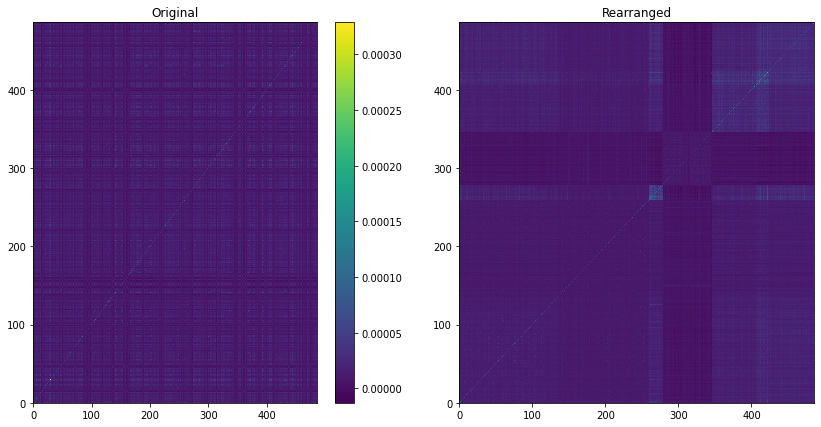

In [ ]:
correlations = pd.DataFrame.cov(df_r[:-1])

plt.figure(figsize = (14,7))
plt.subplot(121)
plt.pcolor(cov)
plt.colorbar()
plt.title('Original')
plt.axis('tight')
plt.subplot(122)
plt.pcolor(correlations)
plt.title('Rearranged')
plt.axis('tight')
plt.show()

In [ ]:
group = dict(df_r.transpose()['Group'])
cov = dict()
for company in group.keys():
  group[company] = int(group[company])
  cov[company] = dict(correlations[company])

In [ ]:
simplified_cov = [[[] for j in range(7)] for i in range(7)]
simplified_mu = [[] for i in range(7)]
for company1 in cov.keys():
  for company2 in cov[company1].keys():
    simplified_cov[group[company1]][group[company2]].append(cov[company1][company2])
  simplified_mu[group[company1]].append(np.mean(r[company1]))
for i in range(7):
  for j in range(7):
    simplified_cov[i][j] = np.mean(simplified_cov[i][j])
  simplified_mu[i] = np.mean(simplified_mu[i])
simplified_cov = np.array(simplified_cov)
simplified_mu = np.array(simplified_mu)

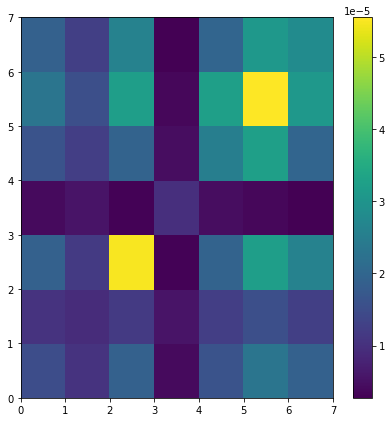

In [ ]:
plt.figure(figsize = (7,7))
plt.pcolor(simplified_cov)
plt.axis('tight')
plt.colorbar()
plt.show()

Quantum approach

In [ ]:
simplified_cov

array([[1.49208036e-05, 1.05181502e-05, 1.89346347e-05, 4.07631209e-06,
        1.63236264e-05, 2.32321542e-05, 1.90269319e-05],
       [1.05181502e-05, 9.20069970e-06, 1.17306966e-05, 5.48734416e-06,
        1.23021646e-05, 1.53311676e-05, 1.25147205e-05],
       [1.89346347e-05, 1.17306966e-05, 5.51323271e-05, 3.09478539e-06,
        1.94108826e-05, 3.22438232e-05, 2.59554817e-05],
       [4.07631209e-06, 5.48734416e-06, 3.09478539e-06, 9.85071668e-06,
        4.56553322e-06, 3.67079347e-06, 2.74718239e-06],
       [1.63236264e-05, 1.23021646e-05, 1.94108826e-05, 4.56553322e-06,
        2.51692022e-05, 3.24340023e-05, 1.98178421e-05],
       [2.32321542e-05, 1.53311676e-05, 3.22438232e-05, 3.67079347e-06,
        3.24340023e-05, 5.55574103e-05, 3.08803809e-05],
       [1.90269319e-05, 1.25147205e-05, 2.59554817e-05, 2.74718239e-06,
        1.98178421e-05, 3.08803809e-05, 2.80106447e-05]])

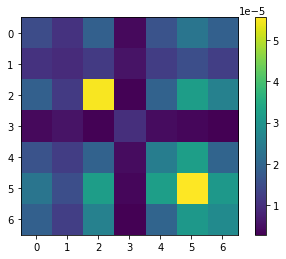

In [ ]:
plt.imshow(simplified_cov)
plt.colorbar()
plt.show()

In [ ]:
num_assets = len(simplified_mu)
q = 0.5                   # set risk factor
budget = 1                # set budget
penalty = 1e5             # set parameter to scale the budget penalty term

qubitOp, offset = portfolio.get_operator(simplified_mu, simplified_cov, q, budget, penalty)

In [ ]:
def index_to_selection(i, num_assets):
    s = "{0:b}".format(i).rjust(num_assets)
    x = np.array([1 if s[i]=='1' else 0 for i in reversed(range(num_assets))])
    return x

def print_result(result):
    selection = sample_most_likely(result.eigenstate)
    value = portfolio.portfolio_value(selection, simplified_mu, simplified_cov, q, budget, penalty)
    print('Optimal: selection {}, value {:.4f}'.format(selection, value))

    eigenvector = result.eigenstate if isinstance(result.eigenstate, np.ndarray) else result.eigenstate.to_matrix()
    probabilities = np.abs(eigenvector)**2
    i_sorted = reversed(np.argsort(probabilities))
    print('\n----------------- Full result ---------------------')
    print('selection\tvalue\t\tprobability')
    print('---------------------------------------------------')
    for i in i_sorted:
        x = index_to_selection(i, num_assets)
        value = portfolio.portfolio_value(x, simplified_mu, simplified_cov, q, budget, penalty)
        probability = probabilities[i]
        print('%10s\t%.4f\t\t%.4f' %(x, value, probability))

In [ ]:
# Exact eigensolver
exact_eigensolver = NumPyMinimumEigensolver(qubitOp)
result = exact_eigensolver.run()

print_result(result)

Optimal: selection [0 0 0 0 0 1 0], value -0.0004

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 1 0]	-0.0004		1.0000
[0 1 1 1 1 1 1]	2499999.9989		0.0000
[1 0 0 0 0 1 0]	99999.9994		0.0000
[0 1 0 0 0 1 0]	99999.9994		0.0000
[1 1 0 0 0 1 0]	399999.9992		0.0000
[0 0 1 0 0 1 0]	99999.9996		0.0000
[1 0 1 0 0 1 0]	399999.9995		0.0000
[0 1 1 0 0 1 0]	399999.9994		0.0000
[1 1 1 0 0 1 0]	899999.9993		0.0000
[0 0 0 1 0 1 0]	99999.9994		0.0000
[1 0 0 1 0 1 0]	399999.9993		0.0000
[0 1 0 1 0 1 0]	399999.9992		0.0000
[1 1 0 1 0 1 0]	899999.9991		0.0000
[0 0 1 1 0 1 0]	399999.9994		0.0000
[1 0 1 1 0 1 0]	899999.9993		0.0000
[0 1 1 1 0 1 0]	899999.9992		0.0000
[1 1 1 1 1 1 1]	3599999.9988		0.0000
[0 0 0 0 1 1 0]	99999.9993		0.0000
[1 0 0 0 1 1 0]	399999.9992		0.0000
[0 1 0 0 1 1 0]	399999.9991		0.0000
[1 1 0 0 1 1 0]	899999.9990		0.0000
[0 0 1 0 1 1 0]	399999.9993		0.0000
[1 0 1 0 1 1 0]	899999.9992		0.

In [ ]:
# VQE eigensolver
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=10000)
ry = TwoLocal(qubitOp.num_qubits, 'ry', 'cz', reps=3, entanglement='full')
vqe = VQE(qubitOp, ry, cobyla)
vqe.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = vqe.run(quantum_instance)

print_result(result)

Optimal: selection [0. 0. 0. 0. 0. 0. 1.], value -0.0002

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[0 0 0 0 0 0 1]	-0.0002		0.9246
[0 0 0 1 0 0 0]	-0.0002		0.0444
[0 0 0 0 1 0 0]	-0.0003		0.0310
[1 0 0 0 0 0 1]	99999.9997		0.0000
[0 0 1 0 0 0 1]	99999.9998		0.0000
[0 1 0 0 0 0 1]	99999.9996		0.0000
[0 1 0 0 1 0 0]	99999.9995		0.0000
[0 1 0 1 0 0 1]	399999.9994		0.0000
[0 0 0 0 1 0 1]	99999.9995		0.0000
[0 0 0 1 0 1 1]	399999.9993		0.0000
[1 0 0 1 0 0 0]	99999.9996		0.0000
[0 0 0 1 0 1 0]	99999.9994		0.0000
[0 0 0 1 0 0 1]	99999.9996		0.0000
[0 0 0 0 1 1 0]	99999.9993		0.0000
[0 0 0 1 1 0 1]	399999.9993		0.0000
[1 0 0 1 1 0 0]	399999.9993		0.0000
[1 0 0 0 1 0 1]	399999.9994		0.0000
[0 0 0 0 0 1 1]	99999.9995		0.0000
[0 0 1 1 0 0 0]	99999.9998		0.0000
[0 1 0 1 0 0 0]	99999.9996		0.0000
[1 0 0 0 1 0 0]	99999.9995		0.0000
[0 0 1 0 1 0 1]	399999.9995		0.0000
[0 1 0 1 1 0 0]	399999.9993		0.0000
[1 0 0

In [ ]:
# QAOA Eigensolver
backend = Aer.get_backend('statevector_simulator')
seed = 50

cobyla = COBYLA()
cobyla.set_options(maxiter=250)
qaoa = QAOA(qubitOp, cobyla, 3)

qaoa.random_seed = seed

quantum_instance = QuantumInstance(backend=backend, seed_simulator=seed, seed_transpiler=seed)

result = qaoa.run(quantum_instance)

print_result(result)

Optimal: selection [1. 1. 1. 1. 1. 1. 1.], value 3599999.9988

----------------- Full result ---------------------
selection	value		probability
---------------------------------------------------
[1 1 1 1 1 1 1]	3599999.9988		0.1025
[1 1 1 1 1 0 1]	2499999.9991		0.0839
[1 1 1 1 0 1 1]	2499999.9990		0.0839
[1 1 1 0 1 1 1]	2499999.9990		0.0839
[1 0 1 1 1 1 1]	2499999.9989		0.0839
[0 1 1 1 1 1 1]	2499999.9989		0.0839
[1 1 1 1 1 1 0]	2499999.9988		0.0839
[1 1 0 1 1 1 1]	2499999.9987		0.0839
[0 0 1 0 0 0 0]	-0.0000		0.0092
[0 0 0 0 0 0 1]	-0.0002		0.0092
[0 0 0 1 0 0 0]	-0.0002		0.0092
[1 0 0 0 0 0 0]	-0.0002		0.0092
[0 1 0 0 0 0 0]	-0.0002		0.0092
[0 0 0 0 1 0 0]	-0.0003		0.0092
[0 0 0 0 0 1 0]	-0.0004		0.0092
[1 0 1 1 0 0 1]	899999.9995		0.0033
[1 1 1 0 0 0 1]	899999.9995		0.0033
[0 1 1 1 0 0 1]	899999.9994		0.0033
[1 1 1 1 0 0 0]	899999.9994		0.0033
[1 0 1 0 1 0 1]	899999.9994		0.0033
[0 0 1 1 1 0 1]	899999.9993		0.0033
[1 0 1 0 0 1 1]	899999.9994		0.0033
[1 0 1 1 1 0 0]	899999.9993		0.0